In [231]:
import pandas as pd 
import numpy as np
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
import gseapy as gp
from gseapy.plot import dotplot
from reactome2py import analysis

In [240]:
# dataset = 'sc_vsmc_dis_hv'
# dataset = 'sc_vsmc_health_hv'
# dataset = 'sc_vsmc_hv'
# dataset = 'sc_endo_hv'
# dataset = 'sc_macro_hv'
# dataset = 'sc_endo_hv_moreedges'
dataset = 'sc_vsmc_hv_moreedges'
dataroot = 'D:/study/thesis/project/HBDM-main/data/datasets/'+dataset+'/'

## modify original network

In [45]:

 
 
sparse_i = np.loadtxt(dataroot+'sparse_i.txt')
sparse_j = np.loadtxt(dataroot+'sparse_j.txt')
sparse_w = np.loadtxt(dataroot+'sparse_w.txt')
 
sparse_i = sparse_i.astype(int)
sparse_j = sparse_j.astype(int)
sparse_w = sparse_w.astype(float)
 
# string_score_transform = np.vectorize(lambda x: -np.log(x/1000))
# transformed_w = string_score_transform(sparse_w)
# transformed_w = 11-(sparse_w*10).round()
edges_and_weights = zip(sparse_i, sparse_j,sparse_w)
 
G = nx.Graph()
 
# Use from_edgelist to directly create the graph from edges
G.add_weighted_edges_from(edges_and_weights)
# len(G.nodes)

FileNotFoundError: D:/study/thesis/project/HBDM-main/data/datasets/sc_macroc_hv/sparse_i.txt not found.

In [56]:
len(G.nodes),len(G.edges)

(5170, 989062)

In [57]:
H = nx.minimum_spanning_tree(G)
existing_edges = list(G.edges())
sample_pool = list(set(existing_edges)-set(H.edges()))
edge_weights = [G[edge[0]][edge[1]]['weight'] for edge in sample_pool]
df = pd.DataFrame({'Node Pair': sample_pool, 'Edge Weight': edge_weights})

In [159]:
int((0.013 * 5170 * (5170 - 1)) / 2)

173704

In [60]:
len(df[df['Edge Weight']>=0.10])

24385

In [61]:
chosen_paris = df[df['Edge Weight']>=0.10]['Node Pair']

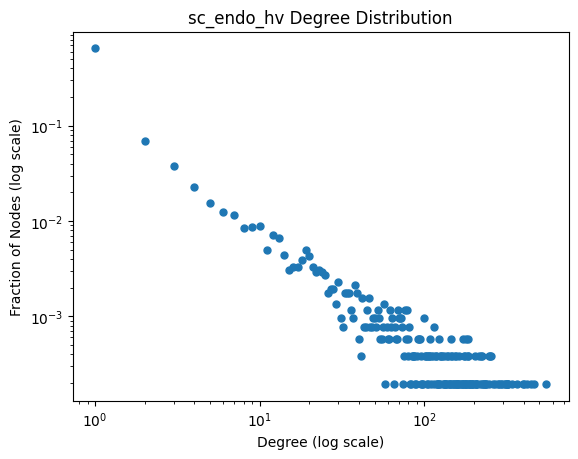

11.432882011605416


In [62]:
remove_pairs = set(sample_pool) - set(chosen_paris.tolist())
G.remove_edges_from(remove_pairs)
graph_df = nx.to_pandas_edgelist(G, source='protein1', target='protein2')
proteins = sorted(list(set(graph_df['protein1'].tolist())|set(graph_df['protein2'].tolist())))
gene2node = {value: index for index, value in enumerate(proteins)}
 
file_path = dataroot+'ppi_index.pkl'
# Serialize and save the Tensor to the file
with open(file_path, 'wb') as file:
    pickle.dump(gene2node, file)
# Close the file
file.close()

graph_df['node1']=graph_df['protein1'].map(gene2node)
graph_df['node2']=graph_df['protein2'].map(gene2node)
G = nx.from_pandas_edgelist(graph_df, source='node1', target='node2', edge_attr='weight', create_using=nx.Graph)

def plot_degree_distribution(name, G, use_weight=False):
    """
    Plot the degree distribution of a graph.
 
    Parameters:
    - G: NetworkX graph
    - use_weight: Boolean, whether to consider edge weights in the degree calculation
    """
 
    # Compute the degree distribution
    if use_weight:
        print('weight')
        degree_sequence = sorted([d for n, d in G.degree(weight="weight")], reverse=True)
    else:
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
 
    degree_counts = nx.degree_histogram(G)
 
    # Convert counts to fractions
    num_nodes = len(G.nodes)
    degree_fraction = [count / num_nodes for count in degree_counts]
 
    # Plot the degree distribution on a log-log scale
    plt.loglog(range(len(degree_fraction)), degree_fraction, 'o', markersize=5)
    plt.title(name+" Degree Distribution")
    plt.xlabel("Degree (log scale)")
    plt.ylabel("Fraction of Nodes (log scale)")
    plt.savefig(dataroot+'degree.png')
    plt.show()
plot_degree_distribution(dataset,G, use_weight=False)
 
degree_sequence = [d for n, d in G.degree()]
# Calculate the average degree
avg_degree = sum(degree_sequence) / len(degree_sequence)
print(avg_degree)
 
edges = np.array([(u, v, data['weight']) for u, v, data in G.edges(data=True)])
 
# Determine i, j, and weights
i = np.where(edges[:, 0] > edges[:, 1], edges[:, 1], edges[:, 0])
j = np.where(edges[:, 0] > edges[:, 1], edges[:, 0], edges[:, 1])
weights = edges[:, 2]
 
 
np.savetxt(dataroot+'sparse_i.txt', np.array(i), delimiter='\n')
np.savetxt(dataroot+'sparse_j.txt', np.array(j), delimiter='\n')
np.savetxt(dataroot+'sparse_w.txt', np.array(weights), delimiter='\n')
 
level_edges = dict()
for u, v, data in G.edges(data=True):
    level = int(str(data['weight']*10)[0])
    if level in level_edges:
        level_edges[level].append([u, v])
    else:
        level_edges[level]=[[u, v]]
 
for level in level_edges:
    edges = np.array(level_edges[level])
    sparse_i = np.where(edges[:, 0] > edges[:, 1], edges[:, 1], edges[:, 0])
    sparse_j = np.where(edges[:, 0] > edges[:, 1], edges[:, 0], edges[:, 1])
    np.savetxt(dataroot+'level_'+str(level)+'_sparse_i.txt', np.array(sparse_i), delimiter='\n')
    np.savetxt(dataroot+'level_'+str(level)+'_sparse_j.txt', np.array(sparse_j), delimiter='\n')

In [3]:
# components = list(nx.connected_components(G))
# # Print information about each connected component
# for i, component in enumerate(components):
#     print(f"Component {i + 1}")

#     # Extract the edges for each component
#     subgraph = G.subgraph(component)
#     component_edges = subgraph.edges()
#     print('nodes',len(subgraph.nodes),'Edges:',len(subgraph.edges))

Component 1
nodes 643 Edges: 14399
Component 2
nodes 25 Edges: 129
Component 3
nodes 2 Edges: 1
Component 4
nodes 10 Edges: 43
Component 5
nodes 2 Edges: 1
Component 6
nodes 22 Edges: 88
Component 7
nodes 2 Edges: 1
Component 8
nodes 3 Edges: 2
Component 9
nodes 2 Edges: 1
Component 10
nodes 20 Edges: 33
Component 11
nodes 4 Edges: 3
Component 12
nodes 2 Edges: 1
Component 13
nodes 14 Edges: 82
Component 14
nodes 13 Edges: 29
Component 15
nodes 2 Edges: 1
Component 16
nodes 3 Edges: 3
Component 17
nodes 7 Edges: 9
Component 18
nodes 4 Edges: 3
Component 19
nodes 2 Edges: 1
Component 20
nodes 2 Edges: 1
Component 21
nodes 4 Edges: 5
Component 22
nodes 6 Edges: 7
Component 23
nodes 3 Edges: 2
Component 24
nodes 2 Edges: 1
Component 25
nodes 4 Edges: 6
Component 26
nodes 2 Edges: 1
Component 27
nodes 2 Edges: 1
Component 28
nodes 2 Edges: 1
Component 29
nodes 2 Edges: 1
Component 30
nodes 3 Edges: 3
Component 31
nodes 4 Edges: 4
Component 32
nodes 2 Edges: 1
Component 33
nodes 3 Edges: 3


## search cad genes

In [241]:
dataroot = 'D:/study/thesis/project/HBDM-main/data/datasets/'+dataset+'/'
 
 
sparse_i = np.loadtxt(dataroot+'sparse_i.txt')
sparse_j = np.loadtxt(dataroot+'sparse_j.txt')
sparse_w = np.loadtxt(dataroot+'sparse_w.txt')
 
sparse_i = sparse_i.astype(int)
sparse_j = sparse_j.astype(int)
sparse_w = sparse_w.astype(float)
 
# string_score_transform = np.vectorize(lambda x: -np.log(x/1000))
# transformed_w = string_score_transform(sparse_w)
# transformed_w = 11-(sparse_w*10).round()
edges_and_weights = zip(sparse_i, sparse_j,sparse_w)
 
G = nx.Graph()
 
# Use from_edgelist to directly create the graph from edges
G.add_weighted_edges_from(edges_and_weights)

In [242]:
len(G.nodes),len(G.edges)

(5168, 154847)

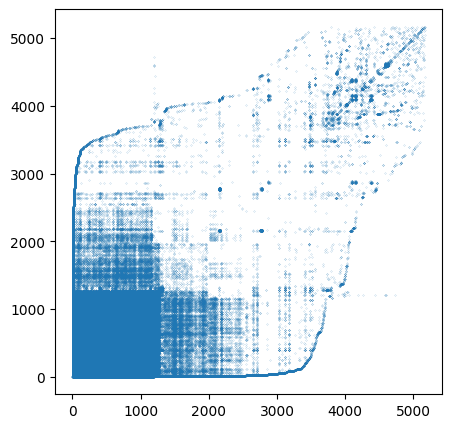

In [243]:
ad = nx.to_numpy_array(G, dtype=bool)
coords = np.argwhere(ad==True)
fig = plt.figure(figsize=(5, 5))
plt.scatter(coords[:,1],coords[:,0],s=0.01)
plt.show()

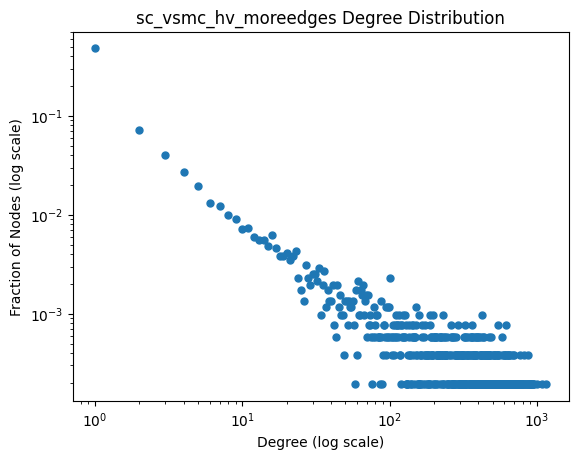

In [244]:
def plot_degree_distribution(name, G, use_weight=False):
    """
    Plot the degree distribution of a graph.
 
    Parameters:
    - G: NetworkX graph
    - use_weight: Boolean, whether to consider edge weights in the degree calculation
    """
 
    # Compute the degree distribution
    if use_weight:
        print('weight')
        degree_sequence = sorted([d for n, d in G.degree(weight="weight")], reverse=True)
    else:
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
 
    degree_counts = nx.degree_histogram(G)
 
    # Convert counts to fractions
    num_nodes = len(G.nodes)
    degree_fraction = [count / num_nodes for count in degree_counts]
 
    # Plot the degree distribution on a log-log scale
    plt.loglog(range(len(degree_fraction)), degree_fraction, 'o', markersize=5)
    plt.title(name+" Degree Distribution")
    plt.xlabel("Degree (log scale)")
    plt.ylabel("Fraction of Nodes (log scale)")
    plt.savefig(root+'degree.png')
    plt.show()
plot_degree_distribution(dataset,G, use_weight=False)

In [245]:
degrees = dict(G.degree())

# Calculate the average node degree
sum(degrees.values()) / len(degrees)

59.92530959752322

In [246]:
len(G.edges()),len(G.nodes())

(154847, 5168)

In [247]:
def calculate_network_density(graph):
    num_nodes = graph.number_of_nodes()
    
    # For undirected graph
    max_edges_undirected = num_nodes * (num_nodes - 1) / 2
    
    # For directed graph
    max_edges_directed = num_nodes * (num_nodes - 1)
    
    # Actual number of edges in the graph
    num_edges = graph.number_of_edges()
    
    # Calculate network density
    density = num_edges / max_edges_undirected  # Change to max_edges_directed for directed graph
    
    return density
calculate_network_density(G)

0.011597698780244478

In [248]:
root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'
# model = 'Dataset-'+dataset+'--RE-True--W-1--Epochs-5000--D-4--RH-25--LR-0.1--LP-False--CUDA-True/'
model = 'Dataset-'+dataset+'--RE-True--W-1--Epochs-4000--D-4--RH-25--LR-0.1--LP-False--CUDA-True/'#macro
# model = 'Dataset-'+dataset+'--RE-True--W-1--Epochs-15000--D-8--RH-25--LR-0.1--LP-False--CUDA-True/'
# model = 'Dataset-'+dataset+'--RE-True--W-1--Epochs-5000--D-4--RH-25--LR-0.1--LP-False--CUDA-True'

In [249]:
with open(dataroot+'ppi_index.pkl', 'rb') as file:
    ppi_index = pickle.load(file)
networkgenes = ppi_index.keys()

caddf = pd.read_csv(r'D:\study\thesis\project\HBDM-main\data\disease\Coronary_artery_disease.tsv',sep='\t')
cadlist = caddf['Gene'].tolist()
all_group_node = []
for gene in cadlist:
    if gene in networkgenes:
        all_group_node.append(ppi_index[gene])

file_path = r'D:\study\thesis\project\HBDM-main\data\disease\novo_ASCVD.txt'
with open(file_path, 'r') as file:
    gene_list = file.readlines()

# Remove newline characters from each gene name
gene_list = [gene.strip() for gene in gene_list]
group_node = []
for gene in gene_list:
    if gene in networkgenes:
        group_node.append(ppi_index[gene])
all_group_node.extend(group_node)

In [250]:
len(all_group_node)

813

In [251]:
file_path = os.path.join(root, model + 'latent.pkl')
with open(file_path, 'rb') as f:
    node_rep = pickle.load(f)
node_rep = np.array(node_rep)
df_latent = pd.DataFrame()
for d in range(node_rep.shape[1]):
    col_name = str(d+1)+'d'
    df_latent[col_name] = node_rep.T[d]
df_latent['node'] = df_latent.index
df = df_latent

# file_path = os.path.join(root, model + 're.pkl')
# with open(file_path, 'rb') as f:
#     re = pickle.load(f)

# node_rep = np.array(node_rep)
# re = np.array(re)
# data = np.concatenate((node_rep, re[:, np.newaxis]), axis=1)
# df_latent = pd.DataFrame()
# for d in range(data.shape[1]):
#     col_name = str(d+1)+'d'
#     df_latent[col_name] = data.T[d]
# df_latent['node'] = df_latent.index
# df = df_latent

In [252]:
len(G.edges()),len(G.nodes()),len(group_node)

(154847, 5168, 141)

In [253]:
cad_G = G.subgraph(group_node)
len(cad_G.edges())

295

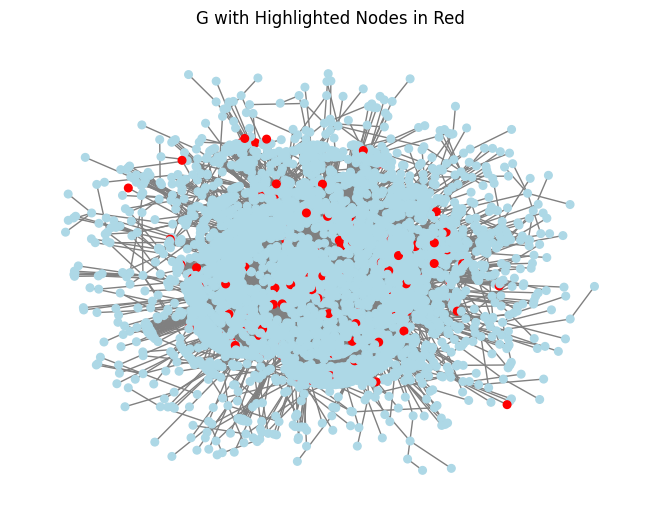

In [83]:
pos = nx.spring_layout(G)  # Layout algorithm (you can choose a different one)
# Set node colors, using red for the selected nodes and lightblue for the rest
node_colors = ['red' if node in group_node else 'lightblue' for node in G.nodes()]

nx.draw(G, pos, with_labels=False, node_size=30, node_color=node_colors,edge_color='gray')
plt.title("G with Highlighted Nodes in Red")
plt.show()

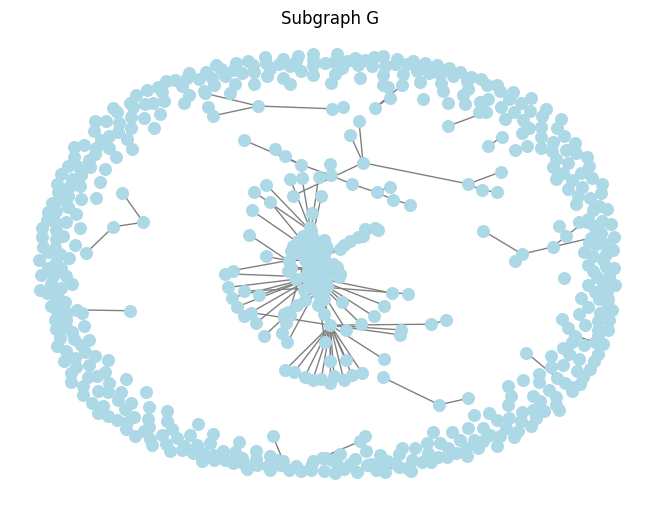

In [10]:
pos = nx.spring_layout(cad_G)  # Layout algorithm (you can choose a different one)
nx.draw(cad_G, pos, with_labels=False, node_size=70, node_color='lightblue', font_color='black', edge_color='gray')
plt.title("Subgraph G")
plt.show()

In [13]:
cad_df = df[df['node'].isin(group_node)]

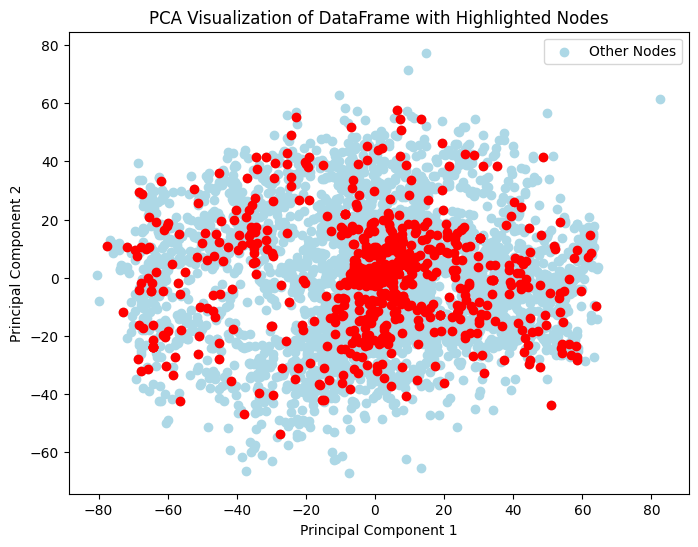

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # You can choose the number of components based on your preference
pca_result = pca.fit_transform(df[['1d', '2d', '3d', '4d', '5d', '6d', '7d', '8d']])

# Create a new DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))

# Plot all points in lightblue
plt.scatter(pca_df['PC1'], pca_df['PC2'], color='lightblue', label='Other Nodes')

# Highlight nodes in red based on the condition
highlighted_nodes = pca_df[df['node'].isin(group_node)]
plt.scatter(highlighted_nodes['PC1'], highlighted_nodes['PC2'], color='red')

plt.title('PCA Visualization of DataFrame with Highlighted Nodes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()  # Show legend for better interpretation

plt.show()

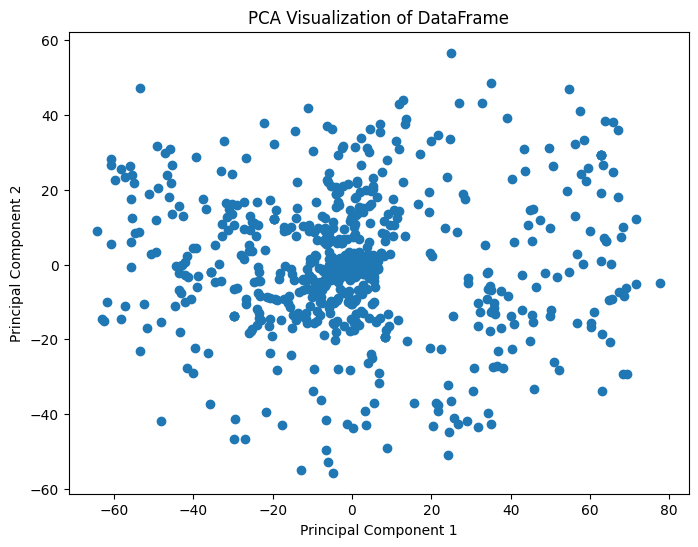

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # You can choose the number of components based on your preference
pca_result = pca.fit_transform(cad_df[['1d', '2d', '3d', '4d', '5d', '6d', '7d', '8d']])

# Create a new DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.title('PCA Visualization of DataFrame')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# # Annotate the points with the original row index (or any relevant information)
# for i, txt in enumerate(cad_df['node']):
#     plt.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]))

plt.show()

In [254]:
from sklearn.cluster import DBSCAN
data = df[['1d', '2d', '3d', '4d', '5d', '6d', '7d', '8d']].to_numpy()

def select_MinPts(data, k):
    k_dist = []
    
    for i in range(data.shape[0]):
        dist = np.linalg.norm(data - data[i], axis=1)
        dist.sort()
        k_dist.append(dist[k])
    
    return np.array(k_dist)
k = 15  # 此处k取 2*2 -1 
k_dist = select_MinPts(data,k)
k_dist.sort()
plt.plot(np.arange(k_dist.shape[0]),k_dist[::-1])
eps = k_dist[::-1][15]
plt.scatter(15,eps,color="r")
plt.plot([0,15],[eps,eps],linestyle="--",color = "r")
plt.plot([15,15],[0,eps],linestyle="--",color = "r")
plt.show()


KeyError: "['5d', '6d', '7d', '8d'] not in index"

In [39]:
eps = 40

In [40]:
dbscan_model = DBSCAN(eps=eps,min_samples=k+1)
labels = dbscan_model.fit_predict(data)

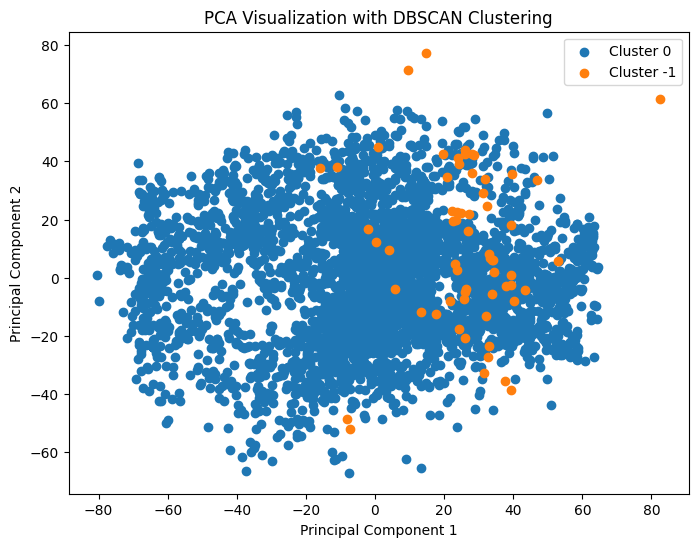

In [42]:
# Create a new DataFrame with the PCA results
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 6))

# Plot points with different cluster labels in different colors
unique_labels = set(labels)
for label in unique_labels:
    cluster_points = pca_df[labels == label]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], label=f'Cluster {label}')

plt.title('PCA Visualization with DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [18]:
from sklearn.neighbors import KDTree

In [19]:
from sklearn.model_selection import KFold
from sklearn import metrics
k_values = [50,100,150,200,250] 
#################################################################################################
# pathways_id = dict(sorted(pathways_id.items(), key=lambda item: item[1], reverse=True)[:10])
outlier = []
#################################################################################################

# for each eomplex, get precision and recall values of varing k
roc_ks = []
pr_ks = []
roc_var_ks = []
pr_var_ks = []

## get final df: node, cluster, 1d, 2d, label
df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
# Set the index to match the values in column 'node'
df = df.set_index('node')
# Reset the index to its default integer index
df = df.reset_index()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for k in k_values:
    k+=1
    results = []

    # Build a k-d tree from the points
    kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
    for train_index, test_index in kf.split(group_node):
        train_nodes = [group_node[i] for i in train_index]
        test_nodes = [group_node[i] for i in test_index]
        start = []
        dist = []
        neighbor = []

        for i in train_nodes:
            given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
            # Perform a k-NN search to find the k+1 nearest neighbors
            distances, indices = kdtree.query(given_point, k=k)
            start += (k-1)*[i]
            dist += distances.reshape(-1).tolist()[1:]
            neighbor += indices.reshape(-1).tolist()[1:]


        neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
        neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(train_nodes)]
        predict_df = neighbor_df['neighbor'].value_counts().to_frame()
        predict_df.reset_index(inplace=True)
        predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
        predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in test_nodes else 0, axis=1)
        if len(predict_df[predict_df['true']==1])==0:
            results.append([0, 0])
        else:
            predicted_positives = predict_df['count']
            true_positives = predict_df['true']
            precision, recall, thresholds = metrics.precision_recall_curve(true_positives,predicted_positives)
            roc,pr= metrics.roc_auc_score(true_positives,predicted_positives),metrics.auc(recall,precision)
            results.append([roc,pr])
    results = np.array(results)
    roc = np.mean(results[:, 0])
    roc_var = np.var(results[:, 0])
    pr = np.mean(results[:, 1])
    pr_var = np.var(results[:, 1])
    roc_ks.append(roc)
    roc_var_ks.append(roc_var)
    pr_ks.append(pr)
    pr_var_ks.append(pr_var)


In [20]:
roc_ks,pr_ks,roc_var_ks,pr_var_ks

([0.5223676894788248,
  0.4998890050823116,
  0.5349196058903118,
  0.5412369154907649,
  0.5548480355961577],
 [0.00819182205741296,
  0.012091881451646828,
  0.00914782406769525,
  0.007639972686334406,
  0.011848623901396727],
 [0.00026437946336118885,
  0.000892272437079236,
  0.0009631039667092466,
  0.0010282460362298553,
  0.0008406901794119062],
 [1.0494735013655786e-06,
  0.00010938011431897699,
  2.3447587939487573e-05,
  2.4465717892699334e-06,
  8.143812992578861e-05])

In [86]:
# health vsmc D=4
roc_ks,pr_ks,roc_var_ks,pr_var_ks

([0.5615388055851602,
  0.566211374712881,
  0.573137122941813,
  0.5734411006821449,
  0.5743253529293406],
 [0.04403198931000948,
  0.04289351318387872,
  0.043292598720325995,
  0.044743126961537025,
  0.04304527071218579],
 [0.0007460666948674586,
  0.0003063047294955937,
  0.00010944158810711963,
  0.00010980777158001884,
  0.0002126652550405346],
 [2.4350629989458254e-05,
  2.203820810572575e-05,
  4.66688091878331e-06,
  5.44117825714863e-06,
  5.55544194663565e-06])

In [77]:
# disease vsmc D=4
roc_ks,pr_ks,roc_var_ks,pr_var_ks

([0.5643102709165244,
  0.5705573145571822,
  0.5691909053530753,
  0.5675347529686569,
  0.5703434939422307],
 [0.042658202508211854,
  0.0437932518661043,
  0.045006387188259014,
  0.048814488053394264,
  0.0457212632462895],
 [0.0006351925063476899,
  0.0003090543173002012,
  0.0004141743810799764,
  0.00047908207601580273,
  0.0005063165871591468],
 [1.926332563790161e-05,
  1.7841093660521204e-05,
  2.839427149267805e-05,
  1.574358584227974e-05,
  2.329493858474056e-05])

([0.5643102709165244,
  0.5705573145571822,
  0.5691909053530753,
  0.5675347529686569,
  0.5703434939422307],
 [0.042658202508211854,
  0.0437932518661043,
  0.045006387188259014,
  0.048814488053394264,
  0.0457212632462895],
 [0.0006351925063476899,
  0.0003090543173002012,
  0.0004141743810799764,
  0.00047908207601580273,
  0.0005063165871591468],
 [1.926332563790161e-05,
  1.7841093660521204e-05,
  2.839427149267805e-05,
  1.574358584227974e-05,
  2.329493858474056e-05])

In [65]:
# disease vsmc D=8
roc_ks,pr_ks,roc_var_ks,pr_var_ks

([0.5787830609269374,
  0.5842025851954649,
  0.5871522198230482,
  0.5909248961037319,
  0.5956389907981865],
 [0.044400981544312386,
  0.048362665056261744,
  0.04973028785289071,
  0.048593728630861574,
  0.05006964687769018],
 [0.0001362734894368351,
  0.0004106063579493842,
  0.0005347322734361962,
  0.0006383906055860984,
  0.0006716031515574406],
 [1.6145492266707576e-05,
  5.3624197460430365e-05,
  4.5497762798437e-05,
  4.314111369024102e-05,
  4.2874877602596954e-05])

([0.5787830609269374,
  0.5842025851954649,
  0.5871522198230482,
  0.5909248961037319,
  0.5956389907981865],
 [0.044400981544312386,
  0.048362665056261744,
  0.04973028785289071,
  0.048593728630861574,
  0.05006964687769018],
 [0.0001362734894368351,
  0.0004106063579493842,
  0.0005347322734361962,
  0.0006383906055860984,
  0.0006716031515574406],
 [1.6145492266707576e-05,
  5.3624197460430365e-05,
  4.5497762798437e-05,
  4.314111369024102e-05,
  4.2874877602596954e-05])

In [23]:
# full vsmc
# roc_ks,pr_ks,roc_var_ks,pr_var_ks

([0.578339549661439,
  0.5832637908813318,
  0.5834498773827272,
  0.5813882945892654,
  0.579817457320143],
 [0.041254927301689,
  0.043845928266322914,
  0.04355901493337782,
  0.0453020368275987,
  0.046614430453689557],
 [0.00025351218856011214,
  8.597516166487989e-05,
  0.00024186110458259904,
  0.00023678605130246939,
  0.0003019493643535892],
 [3.1176888537505225e-05,
  3.875999202389595e-05,
  2.1006409449695332e-05,
  3.258280513197059e-05,
  4.020179030958928e-05])

([0.578339549661439,
  0.5832637908813318,
  0.5834498773827272,
  0.5813882945892654,
  0.579817457320143],
 [0.041254927301689,
  0.043845928266322914,
  0.04355901493337782,
  0.0453020368275987,
  0.046614430453689557],
 [0.00025351218856011214,
  8.597516166487989e-05,
  0.00024186110458259904,
  0.00023678605130246939,
  0.0003019493643535892],
 [3.1176888537505225e-05,
  3.875999202389595e-05,
  2.1006409449695332e-05,
  3.258280513197059e-05,
  4.020179030958928e-05])

In [181]:
## health
top = 5
ks = [5,10,15,20,50,100]
# ks = [50,100,150,200,250]
kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
for k in ks:
    start = []
    dist = []
    neighbor = []
    for i in group_node:
        given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
        # Perform a k-NN search to find the k+1 nearest neighbors
        distances, indices = kdtree.query(given_point, k=k)
        start += (k-1)*[i]
        dist += distances.reshape(-1).tolist()[1:]
        neighbor += indices.reshape(-1).tolist()[1:]


    neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
    # neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(group_node)]
    predict_df = neighbor_df['neighbor'].value_counts().to_frame()
    predict_df.reset_index(inplace=True)
    predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
    predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in group_node else 0, axis=1)
    selected_df = predict_df.head(top)
    print(k,len(selected_df[selected_df['true']==1])/top)

5 0.0
10 0.0
15 0.0
20 0.0
50 0.0
100 0.0


In [25]:
## all?
top = 5
ks = [5,10,15,20,50,100]
# ks = [50,100,150,200,250]
kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
for k in ks:
    start = []
    dist = []
    neighbor = []
    for i in group_node:
        given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
        # Perform a k-NN search to find the k+1 nearest neighbors
        distances, indices = kdtree.query(given_point, k=k)
        start += (k-1)*[i]
        dist += distances.reshape(-1).tolist()[1:]
        neighbor += indices.reshape(-1).tolist()[1:]


    neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
    # neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(group_node)]
    predict_df = neighbor_df['neighbor'].value_counts().to_frame()
    predict_df.reset_index(inplace=True)
    predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
    predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in group_node else 0, axis=1)
    selected_df = predict_df.head(top)
    print(k,len(selected_df[selected_df['true']==1])/top)

5 0.2
10 0.0
15 0.4
20 0.4
50 0.0
100 0.0


In [16]:
### disease only
roc_ks,pr_ks,roc_var_ks,pr_var_ks

([0.5787830609269374,
  0.5842025851954649,
  0.5871522198230482,
  0.5909248961037319,
  0.5956389907981865],
 [0.044400981544312386,
  0.048362665056261744,
  0.04973028785289071,
  0.048593728630861574,
  0.05006964687769018],
 [0.0001362734894368351,
  0.0004106063579493842,
  0.0005347322734361962,
  0.0006383906055860984,
  0.0006716031515574406],
 [1.6145492266707576e-05,
  5.3624197460430365e-05,
  4.5497762798437e-05,
  4.314111369024102e-05,
  4.2874877602596954e-05])

In [191]:
top = 5
ks = [2,3,4,5,10,15,20,50,100]
# ks = [50,100,150,200,250]
kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
for k in ks:
    start = []
    dist = []
    neighbor = []
    for i in group_node:
        given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
        # Perform a k-NN search to find the k+1 nearest neighbors
        distances, indices = kdtree.query(given_point, k=k)
        start += (k-1)*[i]
        dist += distances.reshape(-1).tolist()[1:]
        neighbor += indices.reshape(-1).tolist()[1:]


    neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
    # neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(group_node)]
    predict_df = neighbor_df['neighbor'].value_counts().to_frame()
    predict_df.reset_index(inplace=True)
    predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
    # predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in group_node else 0, axis=1)
    predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in all_group_node else 0, axis=1)
    selected_df = predict_df.head(top)
    print(k,len(selected_df[selected_df['true']==1])/top)

2 0.0
3 0.4
4 0.4
5 0.4
10 0.0
15 0.2
20 0.2
50 0.2
100 0.2


In [192]:
start = []
dist = []
neighbor = []
k = 5
for i in group_node:
    given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
    # Perform a k-NN search to find the k+1 nearest neighbors
    distances, indices = kdtree.query(given_point, k=k)
    start += (k-1)*[i]
    dist += distances.reshape(-1).tolist()[1:]
    neighbor += indices.reshape(-1).tolist()[1:]


neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
# neighbor_df = neighbor_df[~neighbor_df['neighbor'].isin(group_node)]
predict_df = neighbor_df['neighbor'].value_counts().to_frame()
predict_df.reset_index(inplace=True)
predict_df.rename(columns={'neighbor':'count','index':'neighbor'},inplace=True)
# predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in group_node else 0, axis=1)
predict_df['true'] = predict_df.apply(lambda row: 1 if row['neighbor'] in all_group_node else 0, axis=1)
selected_df = predict_df.head(top)
print(k,len(selected_df[selected_df['true']==1])/top)

5 0.4


In [193]:
node2string = {v: k for k, v in ppi_index.items()}
selected_df['gene'] = selected_df['neighbor'].map(node2string.get)
selected_df

C:\Users\ZZY\AppData\Local\Temp\ipykernel_18920\2012012341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['gene'] = selected_df['neighbor'].map(node2string.get)


,neighbor,count,true,gene
0,690,2,0,GPR183
1,181,2,1,BMP7
2,1604,2,1,STAT1
3,1056,2,0,MCUB
4,651,2,0,GBP1


In [194]:
# macro
selected_df['gene'],selected_df['true']

(0    GPR183
 1      BMP7
 2     STAT1
 3      MCUB
 4      GBP1
 Name: gene, dtype: object,
 0    0
 1    1
 2    1
 3    0
 4    0
 Name: true, dtype: int64)

In [185]:
# endo
selected_df['gene'],selected_df['true']

(0        VWF
 1      BMPR2
 2      SSTR1
 3    DNAJC12
 4        LOX
 Name: gene, dtype: object,
 0    1
 1    1
 2    0
 3    0
 4    1
 Name: true, dtype: int64)

In [171]:
# vsmc
selected_df['gene'],selected_df['true']

(0    PCOLCE
 1      NNMT
 2       LUM
 3       F2R
 4      CYBA
 Name: gene, dtype: object,
 0    0
 1    1
 2    1
 3    1
 4    1
 Name: true, dtype: int64)

### cad cluster

In [255]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import gseapy as gp

In [256]:
# Specify the variable names
# variable_names = ['k_exp_dist','final_idx', 'general_cl_id', 'general_mask']
variable_names = ['k_exp_dist', 'general_cl_id', 'general_mask']
# Initialize a dictionary to store the loaded variables
loaded_variables = {}

# Loop through the variable names and load the data from pickle files
for var_name in variable_names:
    file_path = os.path.join(root,model, var_name + '.pkl')
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    loaded_variables[var_name] = loaded_data

# Access the loaded variables as needed
k_exp_dist = loaded_variables['k_exp_dist']
# final_idx = loaded_variables['final_idx']
general_cl_id = loaded_variables['general_cl_id']
general_mask = loaded_variables['general_mask']

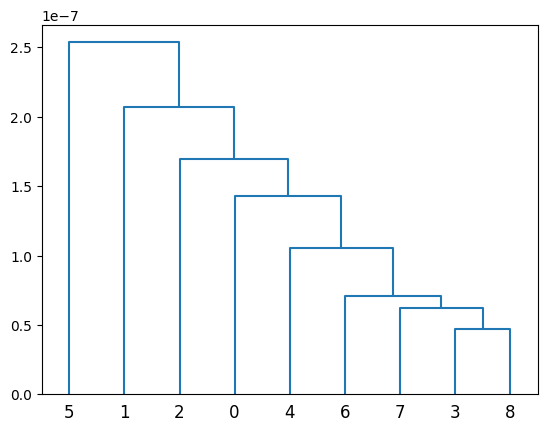

In [257]:
k_exp_dist = np.array(k_exp_dist)
# Create your matrix of within-cluster Euclidean distances
first_level_cls = len(set(list(general_cl_id[0])))
distance_matrix = k_exp_dist[:first_level_cls,:first_level_cls]
# distance_matrix = k_exp_dist[30:70,30:70]
# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='average')
dendrogram = sch.dendrogram(linkage_matrix, color_threshold=0)

# plt.title('Post-Processing Agglomerative Clustering Dendrogram')
# plt.xlabel('Clusters')
# plt.ylabel('Euclidean Distance')
# plt.savefig(pltroot+'Dendrogram-'+name+'.png')
# plt.show()

order = dendrogram['leaves']

In [258]:
level_list = []
# check the cluster ids in different levels
for i in general_cl_id:
    a = list(set(i))
    level_list.append(a)
    print(a)

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
[128, 129, 130, 131, 132, 133, 134, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
[135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 

In [259]:
index_dict = dict()
for i, l in enumerate(general_cl_id):
    for j, cluster in enumerate(l):
        if cluster in index_dict:
            index_dict[cluster].append(general_mask[i][j])
        else:
            index_dict[cluster] = [general_mask[i][j]]

In [260]:
level_dict = dict()
for i in range(len(level_list)):
    if i == len(level_list)-1:
        l = level_list[i]
        for c1 in l:
            level_dict[c1] = []
    else:
        l = level_list[i]
        subl = level_list[i+1]
        # print(l,subl)
        for c1 in l:
            # print(c1)
            for c2 in subl:
                # print(c2)
                if set(index_dict[c1]) & set(index_dict[c2]):
                    # print(c2 ,'in',c1)
                    if c1 in level_dict:
                        level_dict[c1].append(c2)
                    else:
                        level_dict[c1] = [c2]
            if c1 not in level_dict:
                level_dict[c1] = []

In [261]:
# temp = dict()
# for level in level_list:
#     for i in level:
#         nodes = index_dict[i]
#         density = len(set(nodes)&set(group_node))/len(nodes)
#         print()

for i in level_list[0]:
    nodes = index_dict[i]
    density = len(set(nodes)&set(group_node))/len(nodes)
    print(i, len(set(nodes)&set(group_node)),density)

0 12 0.02197802197802198
1 6 0.013100436681222707
2 16 0.035555555555555556
3 8 0.016194331983805668
4 13 0.021311475409836064
5 35 0.04985754985754986
6 11 0.019642857142857142
7 21 0.026854219948849106
8 19 0.03356890459363958


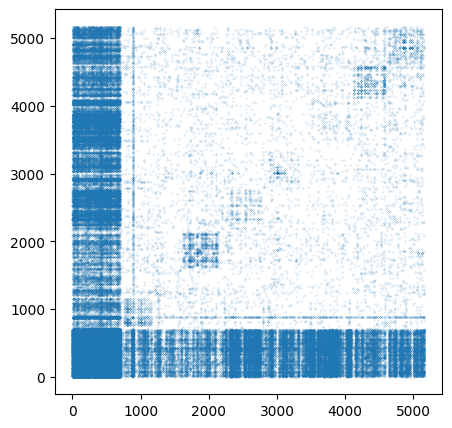

In [262]:
index = []
for i in order:
    index.extend(index_dict[i])
len(index)
ad = nx.to_numpy_array(G, dtype=bool, nodelist=index)
coords = np.argwhere(ad==True)
fig = plt.figure(figsize=(5, 5))
plt.scatter(coords[:,1],coords[:,0],s=0.01)
plt.show()

In [263]:
order

[5, 1, 2, 0, 4, 6, 7, 3, 8]

In [264]:
len(index_dict[1]),len(index_dict[3]),len(index_dict[4]),len(index_dict[5]),len(index_dict[6]),len(index_dict[7]),len(index_dict[8])

(458, 494, 610, 702, 560, 782, 566)

In [37]:
len(index_dict[1]),len(index_dict[3]),len(index_dict[4]),len(index_dict[5]),len(index_dict[6]),len(index_dict[7]),len(index_dict[8])

(272, 1064, 815, 733, 406, 396, 482)

In [265]:
subgraph = G.subgraph(index_dict[5])

In [266]:
# Calculate the degrees of all nodes
degrees = dict(subgraph.degree())
# Calculate the average node degree
avg_degree1 = sum(degrees.values()) / len(degrees)

# Calculate the degrees of all nodes
degrees = dict(G.degree())
# Calculate the average node degree
avg_degree2 = sum(degrees.values()) / len(degrees)
avg_degree1,avg_degree2

(288.0854700854701, 59.92530959752322)

In [38]:
from random import sample
def enrichgene(query_genes,database):
    enr = gp.enrichr(gene_list=query_genes,
                    gene_sets=database,
                    organism='human', 
                    outdir=None, 
                    )
    enrich_results = enr.results
    enrich_results = enrich_results[enrich_results['P-value']<0.01]
    max_value = enrich_results['Combined Score'].replace(float('inf'), np.nan).max()
    enrich_results['Combined Score'].replace(float('inf'), max_value, inplace=True)
    enrich_results=enrich_results[enrich_results['Combined Score']>1]
    log_transformed_values = np.log(enrich_results['Combined Score'])
    return log_transformed_values
def cluster_gene_enrich(query_genes,clustername):
    for database in [['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021','KEGG_2019_Human','Reactome_2022']]:
        enrich1 = enrichgene(query_genes,'GO_Biological_Process_2021')
        randomgenes = sample(networkgenes,len(query_genes))
        enrichrandom = enrichgene(randomgenes,'GO_Biological_Process_2021')
        bin_edges = np.histogram(enrich1, bins=30)[1]
        plt.hist(enrich1, bins=bin_edges, edgecolor='black', alpha=0.5, label=clustername)
        plt.hist(enrichrandom, bins=bin_edges, edgecolor='black', alpha=0.5, label='Random gene set')

        # plt.title(database)
        plt.xlabel('Log(Combined Score)')
        plt.ylabel('Count')
        plt.legend()  # Show legend with labels for each set
        plt.show()

C:\Users\ZZY\AppData\Local\Temp\ipykernel_18920\131907792.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_results['Combined Score'].replace(float('inf'), max_value, inplace=True)
C:\Users\ZZY\AppData\Local\Temp\ipykernel_18920\131907792.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enrich_results['Combined Score'].replace(float('inf'), max_value, inplace=True)


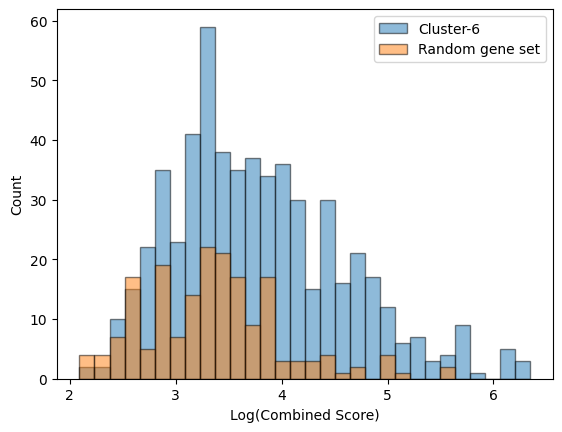

In [39]:
interest_nodes = index_dict[4]

query_genes = list(map(node2string.get,interest_nodes))
cluster_gene_enrich(query_genes,'Cluster-6')

In [267]:
interest_nodes = index_dict[5]

query_genes = list(map(node2string.get,interest_nodes))

In [215]:
import scanpy as sc
import pandas as pd
import numpy as np
scpath = r'D:\study\thesis\project\data\scVI_Atherosclerosis_Atlas_V2.h5ad'
sc_dat = sc.read_h5ad(scpath)

In [218]:
background_genelist = sc_dat.var_names.tolist()

In [224]:
query_genes = [gene for gene in query_genes if gene is not None]

In [229]:
len(query_genes)

268

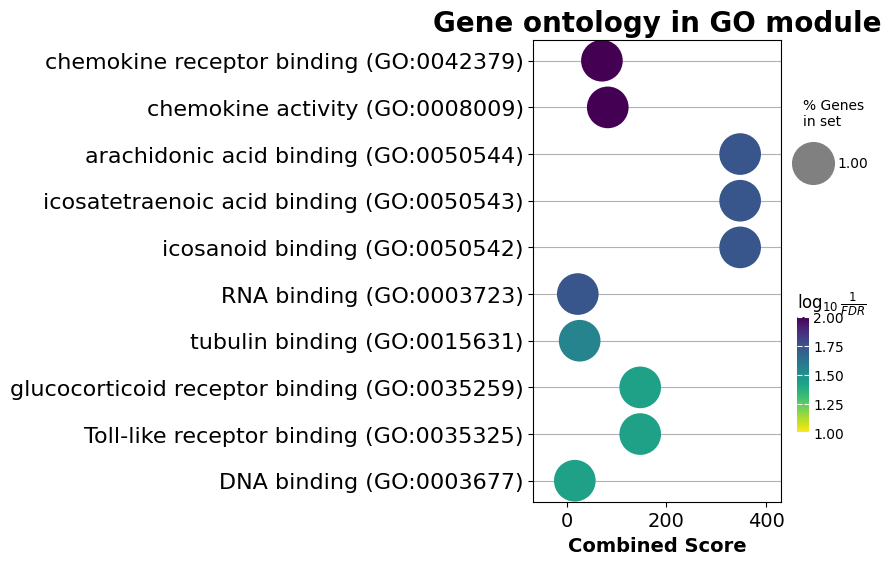

In [228]:
enr = gp.enrichr(gene_list=query_genes,
                gene_sets=['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021'],
                organism='human',
                background=background_genelist,  # Set your background genes here
                #outdir=r"D:\study\thesis\project\HBDM-main\ppi_results\gene_enrichment",
                cutoff=0.05)

ax = dotplot(enr.res2d,
            title=f"Gene ontology in GO module",
            cmap='viridis_r',
            cutoff=0.05)

In [66]:
enr = gp.enrichr(gene_list=query_genes,
                # gene_sets=['GO_Biological_Process_2021','GO_Cellular_Component_2021','GO_Molecular_Function_2021'],
                 gene_sets=['KEGG_2019_Human'],
                organism='human', 
                outdir=None, 
                )
enrich_results = enr.results

In [ ]:
cell-cell adhesion mediator activity
platelet-derived growth factor binding

In [68]:
# enrich_results[enrich_results['Term'].str.contains('cell-cell adhesion mediator activity', case=False)]
enrich_results[enrich_results['Term'].str.contains('focal adhesion', case=False)]['Genes'].tolist()

['ITGB1;ITGB5;LAMA3;TNC;PDGFA;ILK;THBS2;THBS1;ACTB;MYL12A;MYLK;ACTG1;CCND2;CCND1;PDGFD;AKT3;FLNA;ITGAV;PDGFRB;JUN;PPP1R12A;CAV2;LAMB2;ACTN1;CAV1;ITGA1;FN1;ACTN4;PTK2;COL1A1;COL1A2;COL4A2;COL4A1;COL6A2;ITGA11;COL6A1;ITGA8;PPP1R12B;MYL9;VCL']

In [63]:
enrich_results[enrich_results['Term'].str.contains('cell-cell adhesion mediator activity', case=False)]['Genes'].tolist().s

['ANXA1;ANXA2;NEXN;CNN3;PDLIM1;KRT18;PALLD;NPTN;CDC42EP1;ESAM;CNTN4;PDLIM5;S100A11']

In [40]:
def gene_enrich(genelist, type, sets=None, save=False):
    p_value = 0.01
    if type not in ["GO", "KEGG", "REACTOME", "WIKIPATHWAY"]:
        print("Type is not valid! it should be one of them GO, KEGG, REACTOME, WIKIPATHWAY")
    else:
        if type == "GO" and sets is None:
            sets = ["GO_Biological_Process_2021", "GO_Cellular_Component_2021", "GO_Molecular_Function_2021"]
        elif type == "KEGG" and sets is None:
            sets = ["KEGG_2016"]
        elif type == "REACTOME" and sets is None:
            sets = ["ReactomeGeneSets"]
        elif type == "WIKIPATHWAY" and sets is None:
            sets = ["WP2016"]
           
        if type in ["GO", "KEGG", "REACTOME", "WIKIPATHWAY"]:
            try:
                enr = gp.enrichr(gene_list=genelist,
                                gene_sets=sets,
                                organism='human',
                                #outdir=r"D:\study\thesis\project\HBDM-main\ppi_results\gene_enrichment",
                                cutoff=p_value)
                ax = dotplot(enr.res2d,
                            title=f"Gene ontology in {type} module",
                            cmap='viridis_r',
                            cutoff=p_value)
                ax.show()
            except:
                print(f"No enrich terms when cutoff = {p_value} in module {type}")
        else:
                numGeneModule = len(geneModule)
                geneModule = ",".join(geneModule)
                p_value = 0.05
                result = analysis.identifiers(ids=geneModule,
                                                species='Homo sapiens',
                                                p_value=str(p_value))
                token = result['summary']['token']
                if save == True:
                        analysis.report(token,
                                        path="/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/results/gene_enrich",
                                        file="report.pdf",
                                        number='50',
                                        species='Homo sapiens')
                token_result = analysis.token(token,
                        species='Homo sapiens',
                        p_value=str(p_value))
 
                print(
                f"{numGeneModule - token_result['identifiersNotFound']} out of {numGeneModule} genes (identifiers) in the sample were found in Reactome.")
                print(
                f"{token_result['resourceSummary'][0]['pathways']} pathways were hit by at least one of them, which {len(token_result['pathways'])} of them have p-value less than {p_value}.")
                print(f"For more information please visit https://reactome.org/PathwayBrowser/#/DTAB=AN&ANALYSIS={token}")

In [269]:
gene_enrich(query_genes,'GO',sets=None,save=False)

No enrich terms when cutoff = 0.01 in module GO


No enrich terms when cutoff = 0.01 in module GO


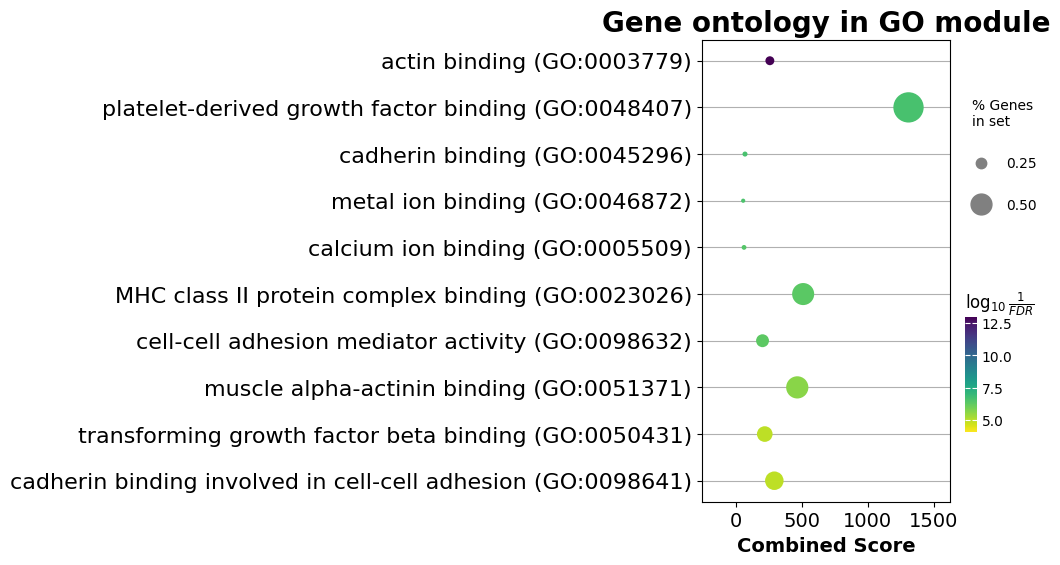

In [41]:
gene_enrich(query_genes,'GO',sets=None,save=False)

No enrich terms when cutoff = 0.01 in module KEGG


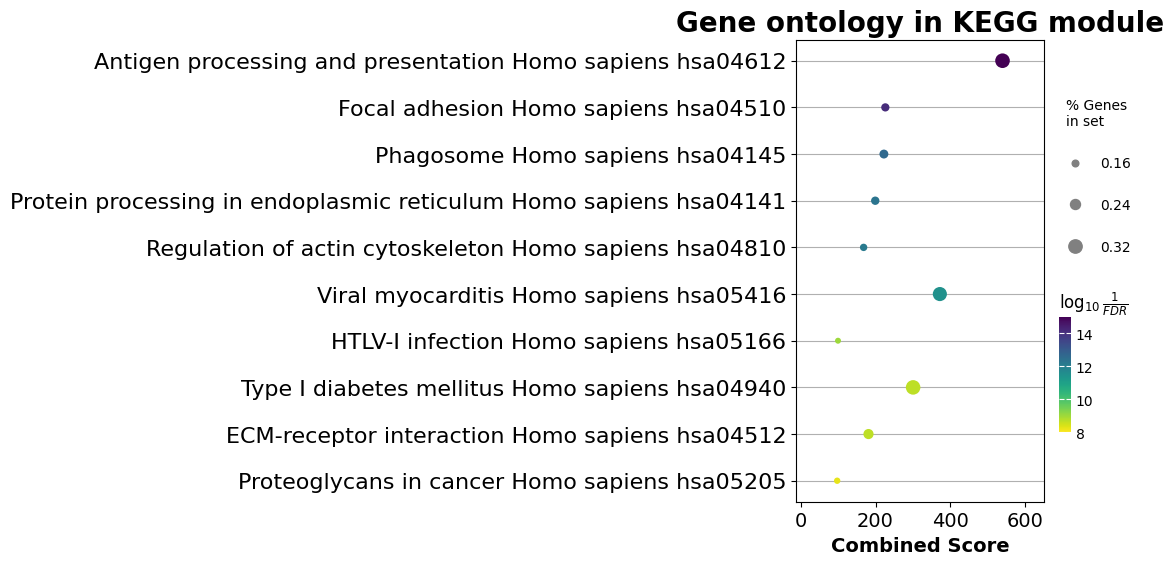

In [42]:
gene_enrich(query_genes,'KEGG',sets=None,save=False)

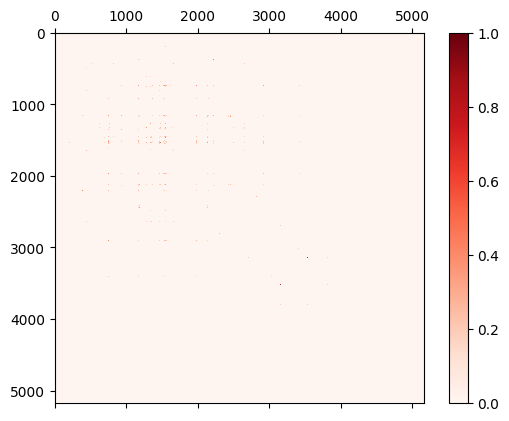

In [35]:
# Get the adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

# Convert the adjacency matrix to a binary matrix
binary_matrix = adj_matrix > 0

# Plot the binary matrix
fig, ax = plt.subplots()
# cax = ax.matshow(binary_matrix, cmap='Reds')
cax = ax.matshow(adj_matrix, cmap='Reds')

# Display the colorbar
fig.colorbar(cax)

plt.show()

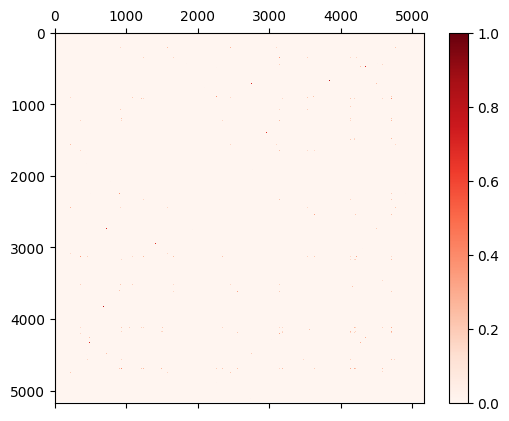

In [24]:
# Get the adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

adj_matrix_reordered = adj_matrix[np.ix_(index, index)]
# binary_matrix = adj_matrix_reordered > 0
# Plot the binary matrix
fig, ax = plt.subplots()
# cax = ax.matshow(binary_matrix, cmap='Reds')
cax = ax.matshow(adj_matrix_reordered, cmap='Reds')
# Display the colorbar
fig.colorbar(cax)

plt.show()

### other levels

In [45]:
# G1 = nx.Graph()
# # Add nodes and edges based on the dictionary
# for node, neighbors in level_dict.items():
#     G1.add_node(node)
#     G1.add_edges_from((node, neighbor) for neighbor in neighbors)
# def find_deep_end_nodes(graph, start_node, depth, current_depth=0, visited=None):
#     if visited is None:
#         visited = set()
#     visited.add(start_node)
    
#     neighbors = list(graph.neighbors(start_node))
    
#     # Check if the current node is at the desired depth
#     if current_depth == depth:
#         return [start_node]
    
#     deep_end_nodes = []
#     for neighbor in neighbors:
#         if neighbor not in visited:
#             deep_end_nodes.extend(find_deep_end_nodes(graph, neighbor, depth, current_depth + 1, visited))
    
#     return deep_end_nodes


# depth = 2
# end_orders = []
# for i in order:
#     start_node = i
#     end_nodes = find_deep_end_nodes(G1, start_node, depth)
#     end_orders.extend(end_nodes)

# index = []
# for i in end_orders:
#     index.extend(index_dict[i])
# len(index)